In [46]:
import sys
sys.path.append('../')
from src.scoring_functions import *
from src.load_data import *

In [47]:
def add_truth(df, source='icosari', disease='sari'):
    df_truth = pd.read_csv(f'https://raw.githubusercontent.com/KITmetricslab/RESPINOW-Hub/main/data/{source}/{disease}/latest_data-{source}-{disease}.csv')
    df_truth = df_truth.rename(columns={'value': 'truth'})

    df = df.merge(df_truth, how='left', 
                   left_on=['location', 'age_group', 'target_end_date'], 
                   right_on=['location', 'age_group', 'date'])
    return df

In [48]:
def load_predictions(source='icosari', disease='sari', period='test', include_median=True, include_truth=True):
    files = glob.glob(f'../data/pre-covid/*.csv') 
    
    dfs = []
    for file in files:
        df_temp = pd.read_csv(file)
        df_temp['model'] = file.split('/')[-1].split('-')[0]
        df_temp['test_year'] = file[-8:-4]
        dfs.append(df_temp)
    df = pd.concat(dfs)
    
    if include_median:
        df = add_median(df)
    if include_truth:
        df = add_truth(df, source, disease)

    return df

In [49]:
df = load_predictions('icosari', 'sari')

In [50]:
df.model.unique()

array(['arima_scaled', 'lightgbm', 'tsmixer', 'arima'], dtype=object)

#### National level

In [51]:
evaluate_models(df, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,lightgbm,188.536407,310.274078,115.395800,614.206285,0.377551,0.724490
1,arima_scaled,316.003487,325.024170,230.089199,871.116856,0.515306,0.923469
2,arima,440.198669,224.441725,300.689906,965.330301,0.688776,0.964286
3,tsmixer,237.324791,432.051378,442.694082,1112.070250,0.193878,0.734694


#### Age groups

In [52]:
evaluate_models(df, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,lightgbm,40.010648,105.510822,48.505088,194.026558,0.237245,0.700680
1,arima_scaled,72.173929,70.835340,59.693798,202.703068,0.474490,0.877551
2,arima,94.077778,61.932899,71.045776,227.056453,0.627551,0.919218
3,tsmixer,59.046167,106.681105,68.383844,234.111116,0.340986,0.835034


# Plots

In [53]:
from plotnine import ggplot, aes, geom_bar, geom_label, scale_alpha_manual, labs, coord_flip, theme_bw, theme, geom_line, scale_alpha_discrete, guide_legend

In [54]:
df = evaluate_models(df, 'national')

In [55]:
scores = pd.melt(df, id_vars=['model'], value_vars=['underprediction', 'spread', 'overprediction'], 
                 var_name='penalty', value_name='value')

In [56]:
df

,model,spread,overprediction,underprediction,wis,c50,c95
0,lightgbm,188.536407,310.274078,115.395800,614.206285,0.377551,0.724490
1,arima_scaled,316.003487,325.024170,230.089199,871.116856,0.515306,0.923469
2,arima,440.198669,224.441725,300.689906,965.330301,0.688776,0.964286
3,tsmixer,237.324791,432.051378,442.694082,1112.070250,0.193878,0.734694


/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


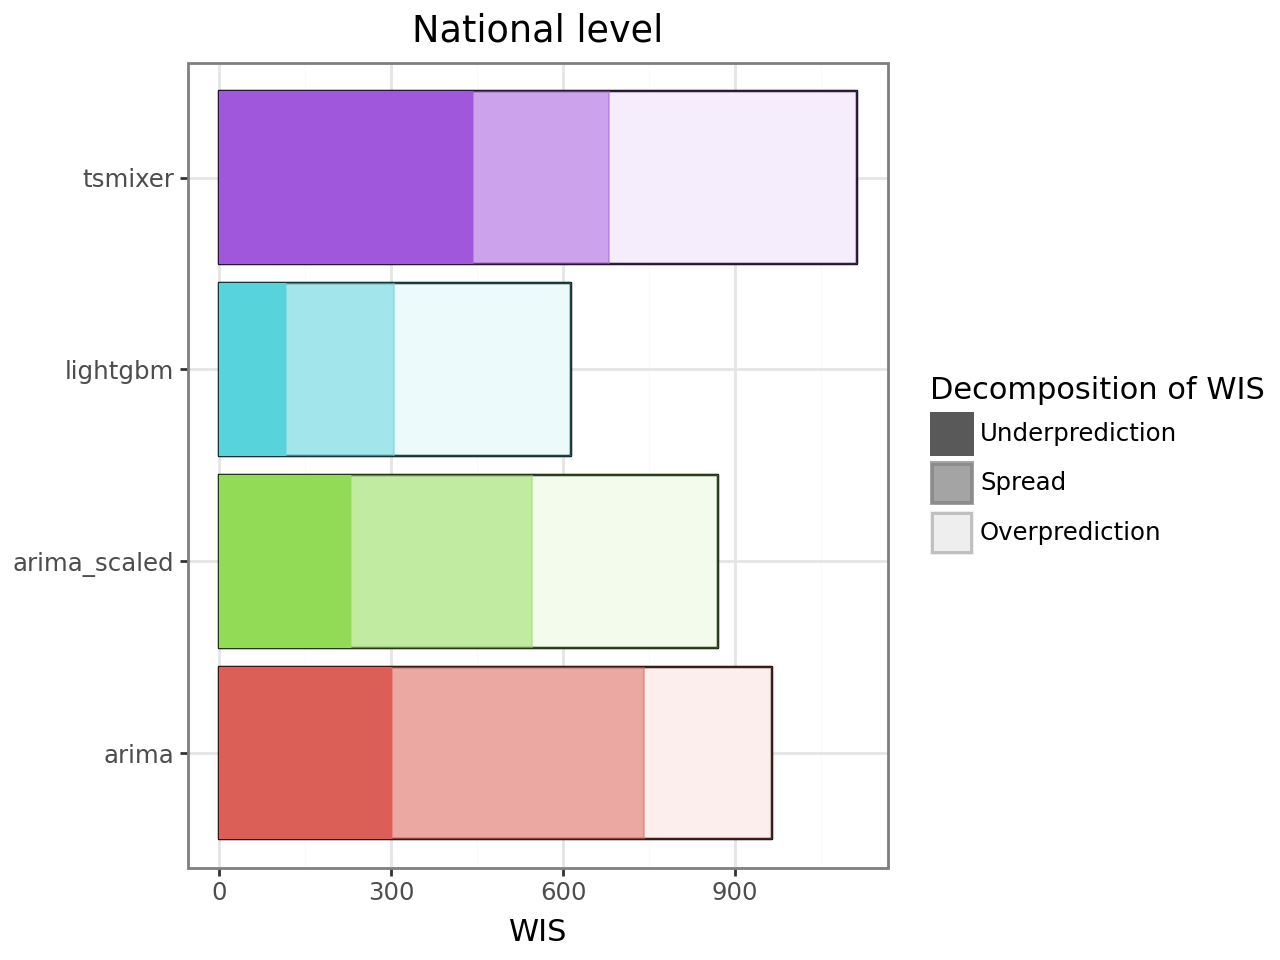

In [57]:
(ggplot()
    + geom_bar(df, aes(x='model', y='wis'), fill='white', color='black', stat='identity')
    + geom_bar(scores, aes(x='model', y='value', fill='model', alpha='penalty', color='model'), size=0.1, stat='identity', 
               show_legend={'color': False,
                            'fill': False,
                            'alpha': True})
    + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=True))
    + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS", title="National level")
    + coord_flip()
    + theme_bw()
    + theme(legend_position='right')
   )